# Exercise 06
# TensorFlow and Keras
### Mónica Gutiérrez - Mario Felipe Garcia


---

### 1. Multilayer neural network in TensorFlow

You need to create a neural network model in TF that is able to discriminate the two classes in the following dataset:

In [2]:
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_moons

%matplotlib inline

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

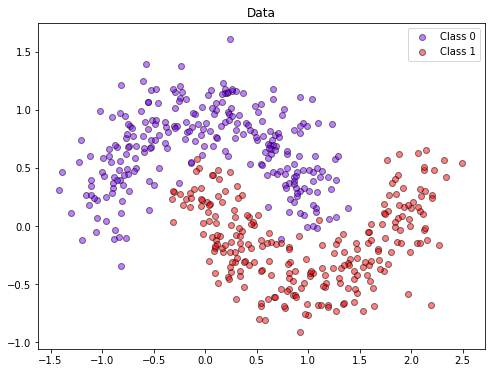

In [3]:
X, Y = make_moons(n_samples=1000, noise= 0.2, random_state=3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

pl.figure(figsize=(8, 6))
plot_data(x_train, y_train)

For this you will need to create a neural network with one hidden layer. You cannot use prebuilt models 
such as those in `tf.estimator`. **Hint**: extend the logistic regression example from the TensorFlow handout. 

Your answer must contain the following:
* A visualization of the CG of the model.
* A visualization of the decision region along with the test data.
* A snapshot from TensorBoard that shows the evolution of the training and test loss.

In [4]:
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

In [5]:
# Helper functions to inline visualization of computing graphs
# Extracted from: 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

In [6]:
RN = 20
graph = tf.Graph()
with graph.as_default():
    
    x = tf.placeholder(tf.float32,shape=[None,2]) 
    y_true = tf.placeholder(tf.float32,shape=None) 
    
    with tf.name_scope('hidden_layer') as scope: 
        w1 = tf.Variable(tf.random_normal([RN,2]),dtype=tf.float32,name='weights_1')
        b1 = tf.Variable(tf.random_normal([RN,1]),dtype=tf.float32,name='bias1') 
   
        h = tf.sigmoid(tf.matmul(w1,tf.transpose(x)) + b1, name='sigmoid')
   
    with tf.name_scope('inference') as scope:
        w2 = tf.Variable(tf.random_normal([1,RN]),dtype=tf.float32,name='weights')
        b = tf.Variable(0,dtype=tf.float32,name='bias') 
        y_pred = tf.sigmoid(tf.matmul(w2,h) + b )

    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss) 
  
    with tf.name_scope('train') as scope:
        learning_rate = 1.0
        optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
        train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    
show_graph(graph.as_graph_def())

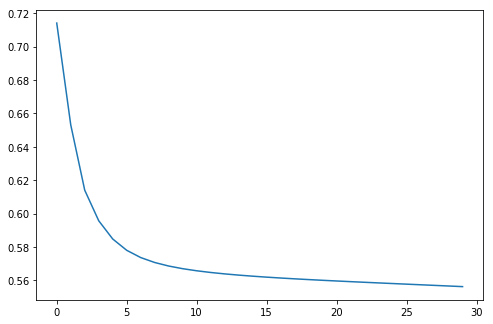

In [7]:
num_epochs = 1500
losses = []

with graph.as_default(): 
    sess = tf.Session()
    sess.run(init)      
    for step in range(num_epochs):
        sess.run(train,{x: x_train, y_true: y_train}) 
        if (step % 50 == 0):
            losses.append(sess.run(loss, {x: x_train, y_true: y_train})) 
                       
pl.figure(figsize = (8,16/3)) 
pl.plot(losses)

[[ 1.4589136  -3.575337  ]
 [-1.2581997  -1.2477993 ]
 [-1.7091603  -0.8004889 ]
 [-0.97016907  2.278016  ]
 [-1.3817738  -0.38530967]
 [-0.8756615   1.7647992 ]
 [ 0.81405723 -0.8197954 ]
 [-1.65482    -0.28932518]
 [-0.5157221   0.3111087 ]
 [-1.9845718  -1.1021554 ]
 [ 1.2125542   0.93550235]
 [-1.105669    2.9233556 ]
 [ 2.0865831   0.00432745]
 [-3.7011974  -2.7712505 ]
 [ 1.786809    0.5855459 ]
 [-0.43771333  0.6924006 ]
 [-0.34214267  0.45674554]
 [-0.77961785  0.81430113]
 [ 1.1559277  -1.0107208 ]
 [-0.17092624 -0.6536755 ]]
[[3.3654927e-05]]


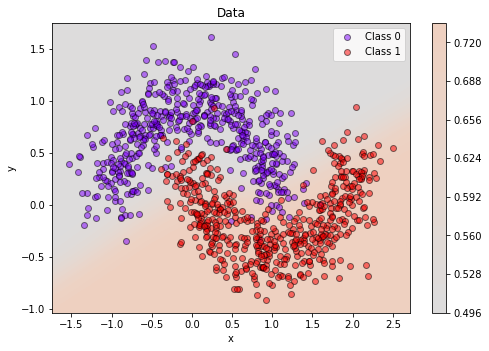

In [8]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

with graph.as_default():
    wval = sess.run(w1)
    print(wval)
    result = sess.run(y_pred, {x:np.array([[1,2]])}) 
    print(result)
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))

pl.figure(figsize = (8,16/3))    
plot_decision_region(X, pred_fun)
plot_data(X, Y)

### 2. Improving the Keras text classifier

Your goal is to improve the performance of the text classifier in the Keras handout. This is are the things that you need to try:

* Different activation functions for the hidden layer (https://keras.io/activations/)
* Different optimizers (https://keras.io/optimizers/)
* Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)
* Different initializers for the dense layers (https://keras.io/initializers/)

Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?


In [9]:
from keras.datasets import reuters
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer

max_words = 1000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

Loading data...
8982 train sequences
2246 test sequences
46 classes


In [10]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
num_words = max(word_index.values()) + 1
words = ['']*num_words
for word in word_index:
    words[word_index[word]] = word

In [11]:
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (8982, 1000)
x_test shape: (2246, 1000)


In [12]:
import keras
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (8982, 46)
y_test shape: (2246, 46)


### Different activation functions for the hidden layer 

##### Sigmoid & Softmax

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_7 (Dense)                (None, 256)                 256256     
______________________________________________________________________
activation_7 (Activation)      (None, 256)                 0          
______________________________________________________________________
dense_8 (Dense)                (None, 46)                  11822      
______________________________________________________________________
activation_8 (Activation)      (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [31]:
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [32]:
batch_size = 32
epochs = 50
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/50
8083/8083 [==============================] - 1s 85us/step - loss: 2.4239 - acc: 0.3530 - val_loss: 2.3320 - val_acc: 0.3315
Epoch 2/50
8083/8083 [==============================] - 1s 65us/step - loss: 2.1904 - acc: 0.4175 - val_loss: 2.1880 - val_acc: 0.4594
Epoch 3/50
8083/8083 [==============================] - 1s 71us/step - loss: 2.0774 - acc: 0.4758 - val_loss: 2.0947 - val_acc: 0.4816
Epoch 4/50
8083/8083 [==============================] - 1s 68us/step - loss: 1.9950 - acc: 0.4986 - val_loss: 2.0222 - val_acc: 0.4994
Epoch 5/50
8083/8083 [==============================] - 1s 68us/step - loss: 1.9315 - acc: 0.5117 - val_loss: 1.9698 - val_acc: 0.5072
Epoch 6/50
8083/8083 [==============================] - 1s 68us/step - loss: 1.8772 - acc: 0.5247 - val_loss: 1.9157 - val_acc: 0.5228
Epoch 7/50
8083/8083 [==============================] - 1s 67us/step - loss: 1.8290 - acc: 0.5430 - val_loss: 1.8701 - val_acc: 0.5306
Epoch 8/

In [33]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 31us/step
Test score: 1.2864100122069633
Test accuracy: 0.7105966162331276


##### Relu & Softmax

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_9 (Dense)                (None, 256)                 256256     
______________________________________________________________________
activation_9 (Activation)      (None, 256)                 0          
______________________________________________________________________
dense_10 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_10 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [35]:
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [36]:
batch_size = 32
epochs = 50
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/50
8083/8083 [==============================] - 1s 94us/step - loss: 2.3944 - acc: 0.4808 - val_loss: 1.9399 - val_acc: 0.5206
Epoch 2/50
8083/8083 [==============================] - 1s 78us/step - loss: 1.7537 - acc: 0.5735 - val_loss: 1.7204 - val_acc: 0.6062
Epoch 3/50
8083/8083 [==============================] - 1s 73us/step - loss: 1.5818 - acc: 0.6308 - val_loss: 1.6014 - val_acc: 0.6630
Epoch 4/50
8083/8083 [==============================] - 1s 81us/step - loss: 1.4670 - acc: 0.6658 - val_loss: 1.5175 - val_acc: 0.6852
Epoch 5/50
8083/8083 [==============================] - 1s 78us/step - loss: 1.3786 - acc: 0.6902 - val_loss: 1.4540 - val_acc: 0.6997
Epoch 6/50
8083/8083 [==============================] - 1s 95us/step - loss: 1.3075 - acc: 0.7121 - val_loss: 1.4043 - val_acc: 0.7030
Epoch 7/50
8083/8083 [==============================] - 1s 96us/step - loss: 1.2475 - acc: 0.7249 - val_loss: 1.3653 - val_acc: 0.7097
Epoch 8/

In [37]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 40us/step
Test score: 0.9446564402202359
Test accuracy: 0.7804986642920748


### Different optimizers

##### RMSprop

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_11 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_11 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_12 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_12 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [39]:
from keras.optimizers import rmsprop
model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop(),
              metrics=['accuracy'])

In [40]:
batch_size = 32
epochs = 50
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/50
8083/8083 [==============================] - 1s 175us/step - loss: 1.3164 - acc: 0.7095 - val_loss: 1.0994 - val_acc: 0.7709
Epoch 2/50
8083/8083 [==============================] - 1s 166us/step - loss: 0.7172 - acc: 0.8366 - val_loss: 0.9480 - val_acc: 0.7853
Epoch 3/50
8083/8083 [==============================] - 1s 167us/step - loss: 0.4985 - acc: 0.8858 - val_loss: 0.9247 - val_acc: 0.8020
Epoch 4/50
8083/8083 [==============================] - 1s 170us/step - loss: 0.3689 - acc: 0.9150 - val_loss: 0.9947 - val_acc: 0.7976
Epoch 5/50
8083/8083 [==============================] - 1s 181us/step - loss: 0.2942 - acc: 0.9296 - val_loss: 1.0468 - val_acc: 0.7953
Epoch 6/50
8083/8083 [==============================] - 2s 207us/step - loss: 0.2510 - acc: 0.9425 - val_loss: 1.1335 - val_acc: 0.7987
Epoch 7/50
8083/8083 [==============================] - 1s 177us/step - loss: 0.2196 - acc: 0.9475 - val_loss: 1.1786 - val_acc: 0.7786
E

In [41]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 29us/step
Test score: 2.252660909722346
Test accuracy: 0.7609082813891362


##### Adam

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_11 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_11 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_12 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_12 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [45]:
from keras.optimizers import adam
model.compile(loss='categorical_crossentropy',
              optimizer=adam(),
              metrics=['accuracy'])

In [46]:
batch_size = 32
epochs = 50
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/50
8083/8083 [==============================] - 1s 170us/step - loss: 0.1490 - acc: 0.9595 - val_loss: 2.1235 - val_acc: 0.7553
Epoch 2/50
8083/8083 [==============================] - 1s 148us/step - loss: 0.1387 - acc: 0.9586 - val_loss: 1.9768 - val_acc: 0.7531
Epoch 3/50
8083/8083 [==============================] - 1s 173us/step - loss: 0.1351 - acc: 0.9569 - val_loss: 2.1159 - val_acc: 0.7486
Epoch 4/50
8083/8083 [==============================] - 1s 148us/step - loss: 0.1208 - acc: 0.9620 - val_loss: 2.0476 - val_acc: 0.7430
Epoch 5/50
8083/8083 [==============================] - 1s 150us/step - loss: 0.1219 - acc: 0.9594 - val_loss: 1.9825 - val_acc: 0.7497
Epoch 6/50
8083/8083 [==============================] - 1s 152us/step - loss: 0.1191 - acc: 0.9579 - val_loss: 2.0684 - val_acc: 0.7497
Epoch 7/50
8083/8083 [==============================] - 1s 153us/step - loss: 0.1276 - acc: 0.9600 - val_loss: 2.0266 - val_acc: 0.7442
E

In [47]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 36us/step
Test score: 2.1159175578123315
Test accuracy: 0.7644701691896705


### Add dropout between the hidden layer and the output layer

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_13 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_13 (Activation)     (None, 256)                 0          
______________________________________________________________________
dropout_1 (Dropout)            (None, 256)                 0          
______________________________________________________________________
dense_14 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_14 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [49]:
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [50]:
batch_size = 32
epochs = 50
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/50
8083/8083 [==============================] - 1s 118us/step - loss: 2.5914 - acc: 0.4210 - val_loss: 2.0114 - val_acc: 0.4994
Epoch 2/50
8083/8083 [==============================] - 1s 89us/step - loss: 1.8971 - acc: 0.5305 - val_loss: 1.7670 - val_acc: 0.5684
Epoch 3/50
8083/8083 [==============================] - 1s 90us/step - loss: 1.7197 - acc: 0.5722 - val_loss: 1.6506 - val_acc: 0.6263
Epoch 4/50
8083/8083 [==============================] - 1s 98us/step - loss: 1.6104 - acc: 0.6176 - val_loss: 1.5698 - val_acc: 0.6463
Epoch 5/50
8083/8083 [==============================] - 1s 106us/step - loss: 1.5353 - acc: 0.6349 - val_loss: 1.5074 - val_acc: 0.6707
Epoch 6/50
8083/8083 [==============================] - 1s 84us/step - loss: 1.4684 - acc: 0.6619 - val_loss: 1.4572 - val_acc: 0.6796
Epoch 7/50
8083/8083 [==============================] - 1s 84us/step - loss: 1.4076 - acc: 0.6780 - val_loss: 1.4146 - val_acc: 0.6930
Epoch 

In [51]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 35us/step
Test score: 0.9397180749174748
Test accuracy: 0.7818343722438132


### Different initializers for the dense layers

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='random_normal'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)


______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_23 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_21 (Activation)     (None, 256)                 0          
______________________________________________________________________
dropout_5 (Dropout)            (None, 256)                 0          
______________________________________________________________________
dense_24 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_22 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [66]:
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [67]:
batch_size = 32
epochs = 50
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/50
8083/8083 [==============================] - 1s 116us/step - loss: 2.5447 - acc: 0.4243 - val_loss: 1.9987 - val_acc: 0.5106
Epoch 2/50
8083/8083 [==============================] - 1s 80us/step - loss: 1.9143 - acc: 0.5270 - val_loss: 1.7862 - val_acc: 0.5506
Epoch 3/50
8083/8083 [==============================] - 1s 78us/step - loss: 1.7526 - acc: 0.5686 - val_loss: 1.6790 - val_acc: 0.5996
Epoch 4/50
8083/8083 [==============================] - 1s 79us/step - loss: 1.6478 - acc: 0.5982 - val_loss: 1.6071 - val_acc: 0.6307
Epoch 5/50
8083/8083 [==============================] - 1s 79us/step - loss: 1.5637 - acc: 0.6287 - val_loss: 1.5427 - val_acc: 0.6585
Epoch 6/50
8083/8083 [==============================] - 1s 89us/step - loss: 1.5101 - acc: 0.6462 - val_loss: 1.4917 - val_acc: 0.6741
Epoch 7/50
8083/8083 [==============================] - 1s 80us/step - loss: 1.4545 - acc: 0.6595 - val_loss: 1.4518 - val_acc: 0.6796
Epoch 8

In [68]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 36us/step
Test score: 0.9542200718197776
Test accuracy: 0.7742653606676779


##### Se realizaron pruebas con 'ones', 'zeros', 'random_normal' entre otros pero el mejor resultado se obtiene con:
- Activación Relu y Softmax
- Optimizer SGD
- Dropout 0.5
- kernel_initializer= Random Uniform
Con estos parametros se obtuvo un accuracy de 0.7818 que fue el más alto que le logró.